In [2]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split

In [28]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


READ DATA

In [29]:
(train_data, test_data), ds_info = tfds.load(name="cifar100",
                                             split=["train", "test"],
                                             shuffle_files=True,
                                             as_supervised=True, # Data gets returned in tuple format (data, label)
                                             with_info=True)

In [30]:
train_data = train_data.concatenate(test_data)

In [31]:
dataset = []
label_var = []
for image, label in tfds.as_numpy(train_data):
  if label not in label_var: label_var.append(label)
  dataset.append({
      'image' : image,
      'label' : int(label)
  })

In [32]:
dataset_per_label = []
for label in label_var:
  dataset_per_label.append([])

for number in dataset:
  dataset_per_label[number['label']].append(number)

In [33]:
percentage = 1
new_data = []

for label in dataset_per_label:
  num = int(len(label) * percentage / 100)
  new_data.append(np.random.choice(label, num, replace=False))

# for i in range(len(new_data)):
#   print(i, len(new_data[i]))

In [34]:
new_data = np.array(new_data)

In [35]:
new_data=new_data.flatten()

In [36]:
len(new_data)

600

In [3]:
import pickle

In [38]:
with open('dataset.pkl', 'wb') as f:
    pickle.dump(new_data, f)

In [39]:
with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [40]:
X = []
Y = []
for i in range(len(new_data)):
  X.append(tf.cast(new_data[i]['image'], tf.float32) / 255)
  Y.append(tf.one_hot(new_data[i]['label'], depth=100))

X = np.array(X)
Y = np.array(Y)

In [41]:
with open('datax.pkl','wb') as f:
    pickle.dump(X, f)

with open('datay.pkl','wb') as f:
    pickle.dump(Y, f)

In [42]:
with open('datax.pkl','rb') as f:
    X = pickle.load(f)
with open('datay.pkl','rb') as f:
    Y = pickle.load(f)

In [43]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

In [44]:
with open('x_train.pkl','wb') as f:
    pickle.dump(Xtrain, f)

with open('y_train.pkl','wb') as f:
    pickle.dump(Ytrain, f)

with open('x_test.pkl','wb') as f:
    pickle.dump(Xtest, f)

with open('y_test.pkl','wb') as f:
    pickle.dump(Ytest, f)

In [4]:
with open('x_train.pkl','rb') as f:
    Xtrain = pickle.load(f)
with open('y_train.pkl','rb') as f:
    Ytrain = pickle.load(f)

with open('x_test.pkl','rb') as f:
    Xtest = pickle.load(f)
with open('y_test.pkl','rb') as f:
    Ytest = pickle.load(f)

Data Plotting

In [5]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss'])) # How many epochs


    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

Alexnet

In [47]:
model = keras.models.Sequential(
    [
        keras.layers.Input(shape=(32,32,3)),
        keras.layers.Conv2D(96, kernel_size=(3,3), strides=(1,1), activation='relu'),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(256, kernel_size=(5,5), activation='relu',padding='same'),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(384, kernel_size=(3,3), activation='relu',padding='same'),
        keras.layers.Conv2D(384, kernel_size=(3,3), activation='relu',padding='same'),
        keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu',padding='same'),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(100, activation='softmax')
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 96)        2688      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 256)       614656    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 6, 6, 384)         885120    
                                                                 
 conv2d_13 (Conv2D)          (None, 6, 6, 384)        

In [48]:
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [49]:
history_alexnet = model.fit(Xtrain, Ytrain,epochs=10, batch_size=16, validation_data=(Xtest,Ytest))

Epoch 1/10


2024-03-07 12:44:46.616848: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-07 12:44:46.813564: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-07 12:44:47.734977: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-07 12:44:48.307047: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f97fb9ca430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-07 12:44:48.307081: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-03-07 12:44:48.316893: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709790288.419458   29534 devic

30/30 [==============================] - 6s 25ms/step - loss: 4.6262 - accuracy: 0.0042 - val_loss: 4.6240 - val_accuracy: 0.0000e+00
Epoch 2/10
30/30 [==============================] - 0s 14ms/step - loss: 4.6046 - accuracy: 0.0063 - val_loss: 4.6446 - val_accuracy: 0.0000e+00
Epoch 3/10
30/30 [==============================] - 0s 14ms/step - loss: 4.6011 - accuracy: 0.0146 - val_loss: 4.7043 - val_accuracy: 0.0000e+00
Epoch 4/10
30/30 [==============================] - 0s 14ms/step - loss: 4.6004 - accuracy: 0.0083 - val_loss: 4.7652 - val_accuracy: 0.0000e+00
Epoch 5/10
30/30 [==============================] - 0s 14ms/step - loss: 4.5971 - accuracy: 0.0063 - val_loss: 4.7705 - val_accuracy: 0.0000e+00
Epoch 6/10
30/30 [==============================] - 0s 14ms/step - loss: 4.5901 - accuracy: 0.0021 - val_loss: 4.7831 - val_accuracy: 0.0000e+00
Epoch 7/10
30/30 [==============================] - 0s 14ms/step - loss: 4.5879 - accuracy: 0.0021 - val_loss: 4.8308 - val_accuracy: 0.0000e

In [50]:
with open('history_alexnet.pkl', 'wb') as f:
    pickle.dump(history_alexnet, f)

In [52]:
with open('history_alexnet.pkl', 'rb') as f:
    history_alexnet = pickle.load(f)

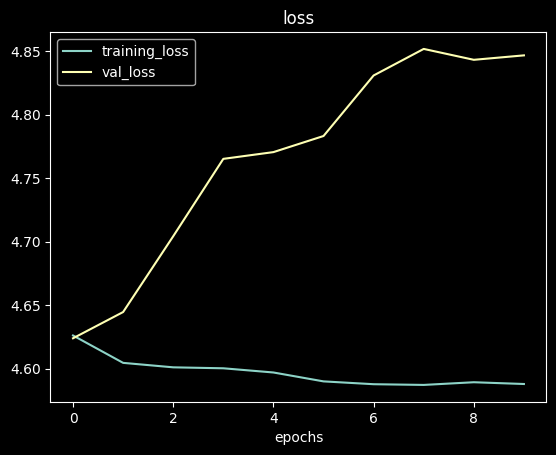

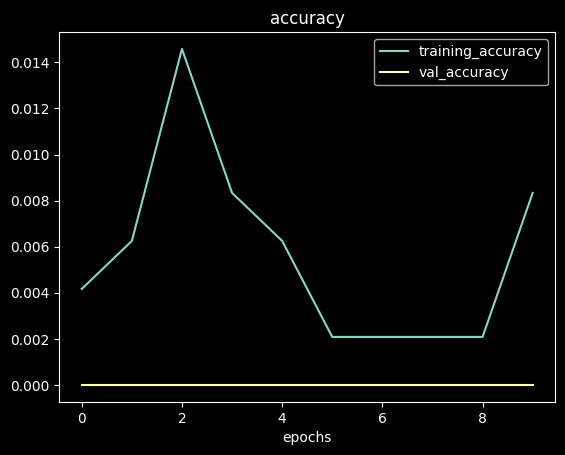

In [53]:
plot_loss_curves(history_alexnet)

LENET

In [54]:
model = keras.models.Sequential(
    [
      keras.layers.Input((32,32,3)),
      keras.layers.Conv2D(6, kernel_size=(5,5), activation='sigmoid'),
      keras.layers.MaxPool2D(pool_size=2, strides=(2,2)),
      keras.layers.Conv2D(16, kernel_size=(5,5), activation='sigmoid'),
      keras.layers.MaxPool2D(pool_size=2, strides=(2,2)),
      keras.layers.Flatten(),
      keras.layers.Dense(120, activation='sigmoid'),
      keras.layers.Dense(84, activation='sigmoid'),
      keras.layers.Dense(100, activation='softmax')
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 14, 14, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 5, 5, 16)          0         
 ng2D)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 400)               0         
                                                                 
 dense_9 (Dense)             (None, 120)              

In [55]:
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [56]:
history_lenet = model.fit(Xtrain, Ytrain,epochs=10, batch_size=16, validation_data=(Xtest,Ytest))

Epoch 1/10


30/30 [==============================] - 3s 21ms/step - loss: 4.7522 - accuracy: 0.0125 - val_loss: 4.7434 - val_accuracy: 0.0000e+00
Epoch 2/10
30/30 [==============================] - 0s 7ms/step - loss: 4.6332 - accuracy: 0.0083 - val_loss: 4.7613 - val_accuracy: 0.0000e+00
Epoch 3/10
30/30 [==============================] - 0s 6ms/step - loss: 4.6080 - accuracy: 0.0042 - val_loss: 4.7925 - val_accuracy: 0.0000e+00
Epoch 4/10
30/30 [==============================] - 0s 6ms/step - loss: 4.6074 - accuracy: 0.0125 - val_loss: 4.8247 - val_accuracy: 0.0000e+00
Epoch 5/10
30/30 [==============================] - 0s 6ms/step - loss: 4.5980 - accuracy: 0.0063 - val_loss: 4.8409 - val_accuracy: 0.0000e+00
Epoch 6/10
30/30 [==============================] - 0s 6ms/step - loss: 4.5987 - accuracy: 0.0083 - val_loss: 4.8443 - val_accuracy: 0.0000e+00
Epoch 7/10
30/30 [==============================] - 0s 6ms/step - loss: 4.5994 - accuracy: 0.0000e+00 - val_loss: 4.8565 - val_accuracy: 0.0000e+0

In [57]:
with open('history_lenet.pkl', 'wb') as f:
    pickle.dump(history_lenet, f)

In [ ]:
with open('history_lenet.pkl', 'rb') as f:
    history_lenet = pickle.load(f)

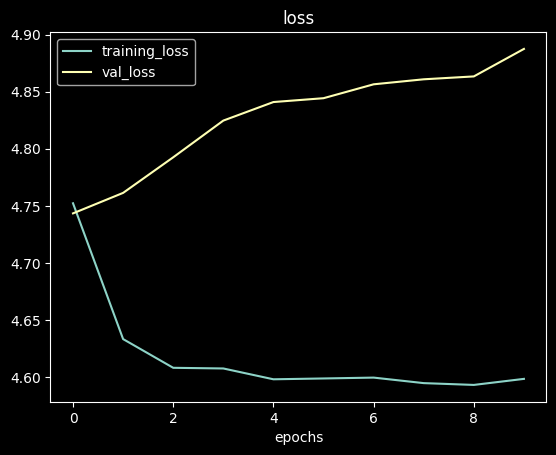

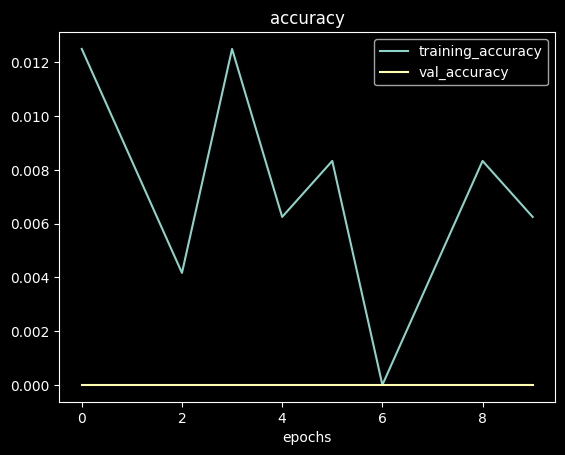

In [58]:
plot_loss_curves(history_lenet)

CUSTOM MODEL

In [7]:
model = keras.models.Sequential(
    [
      keras.layers.Input((32,32,3)),

      keras.layers.Conv2D(6, kernel_size=(5,5), activation='relu'),
      keras.layers.Conv2D(12, kernel_size=(5,5), activation='relu', padding='same'),

      keras.layers.MaxPool2D(pool_size=2, strides=(2,2)),
      keras.layers.Conv2D(16, kernel_size=(5,5), activation='relu', padding='same'),
      keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),
      keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),
      keras.layers.MaxPool2D(pool_size=2, strides=(2,2)),

      keras.layers.Flatten(),
      keras.layers.Dense(120, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(84, activation='relu'),

      keras.layers.Dense(100, activation='softmax')
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 6)         456       
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 12)        1812      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 12)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 16)        4816      
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 32)        9248      
                                                      

In [8]:
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [9]:
history_custom = model.fit(Xtrain, Ytrain,epochs=10, batch_size=16, validation_data=(Xtest,Ytest))

Epoch 1/10


2024-03-07 15:02:47.364576: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-07 15:02:47.543329: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-07 15:02:49.929228: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-07 15:02:51.822523: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff52b15c2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-07 15:02:51.822556: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-03-07 15:02:51.832565: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709798571.914594   24088 devic

30/30 [==============================] - 11s 24ms/step - loss: 4.6095 - accuracy: 0.0104 - val_loss: 4.6097 - val_accuracy: 0.0083
Epoch 2/10
30/30 [==============================] - 2s 63ms/step - loss: 4.6047 - accuracy: 0.0063 - val_loss: 4.6151 - val_accuracy: 0.0083
Epoch 3/10
30/30 [==============================] - 0s 7ms/step - loss: 4.6031 - accuracy: 0.0083 - val_loss: 4.6252 - val_accuracy: 0.0000e+00
Epoch 4/10
30/30 [==============================] - 0s 7ms/step - loss: 4.6057 - accuracy: 0.0083 - val_loss: 4.6331 - val_accuracy: 0.0000e+00
Epoch 5/10
30/30 [==============================] - 0s 7ms/step - loss: 4.5989 - accuracy: 0.0104 - val_loss: 4.6555 - val_accuracy: 0.0000e+00
Epoch 6/10
30/30 [==============================] - 0s 7ms/step - loss: 4.5981 - accuracy: 0.0167 - val_loss: 4.6816 - val_accuracy: 0.0000e+00
Epoch 7/10
30/30 [==============================] - 2s 61ms/step - loss: 4.5932 - accuracy: 0.0083 - val_loss: 4.7346 - val_accuracy: 0.0000e+00
Epoch 8

In [10]:
with open('history_custom.pkl', 'wb') as f:
    pickle.dump(history_custom, f)

In [ ]:
with open('history_lenet.pkl', 'rb') as f:
    history_custom = pickle.load(f)

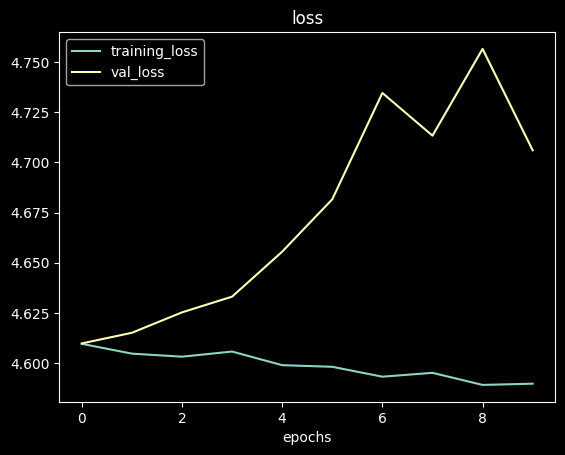

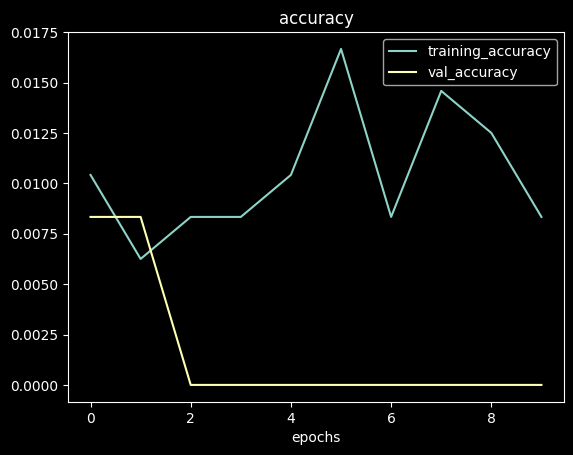

In [11]:
plot_loss_curves(history_custom)